INGENIERÍA DEL DATO

In [1]:
#Librerías utilizadas

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import kurtosis, skew, norm
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
import hdbscan
from sklearn.decomposition import PCA


In [2]:
# Carga del dataset

file_path = "/content/cscpopendata.csv"
df = pd.read_csv(file_path, sep=',', engine="python")
print("Datos cargados correctamente")

Datos cargados correctamente


In [3]:
# Estructura de los datos

print("Número de filas y columnas:", df.shape)
print("\nPrimeras filas del dataset:")
print(f"Total de registros en la base de datos inicial: {df.shape[0]}")
display(df.head())

print("\nTipos de datos:")
print(df.dtypes)

Número de filas y columnas: (114635, 22)

Primeras filas del dataset:
Total de registros en la base de datos inicial: 114635


,CDPHId,ProductName,CSFId,CSF,CompanyId,CompanyName,BrandName,PrimaryCategoryId,PrimaryCategory,SubCategoryId,...,CasNumber,ChemicalId,ChemicalName,InitialDateReported,MostRecentDateReported,DiscontinuedDate,ChemicalCreatedAt,ChemicalUpdatedAt,ChemicalDateRemoved,ChemicalCount
0,2,ULTRA COLOR RICH EXTRA PLUMP LIPSTICK-ALL SHADES,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),53,...,13463-67-7,6,Titanium dioxide,06/17/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1
1,3,Glover's Medicated Shampoo,NaN,NaN,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,65996-92-1,4,Distillates (coal tar),07/01/2009,07/01/2009,NaN,07/01/2009,07/01/2009,NaN,2
2,3,Glover's Medicated Shampoo,NaN,NaN,338,J. Strickland & Co.,Glover's,18,Hair Care Products (non-coloring),25,...,140-67-0,5,Estragole,07/01/2009,07/01/2009,NaN,07/02/2009,07/02/2009,NaN,2
3,4,PRECISION GLIMMER EYE LINER-ALL SHADES �,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),46,...,13463-67-7,7,Titanium dioxide,07/09/2009,08/28/2013,NaN,07/09/2009,07/09/2009,NaN,1
4,5,AVON BRILLIANT SHINE LIP GLOSS-ALL SHADES �,NaN,NaN,4,New Avon LLC,AVON,44,Makeup Products (non-permanent),52,...,13463-67-7,8,Titanium dioxide,07/09/2009,08/28/2013,02/01/2011,07/09/2009,07/09/2009,NaN,1



Tipos de datos:
CDPHId                      int64
ProductName                object
CSFId                     float64
CSF                        object
CompanyId                   int64
CompanyName                object
BrandName                  object
PrimaryCategoryId           int64
PrimaryCategory            object
SubCategoryId               int64
SubCategory                object
CasId                       int64
CasNumber                  object
ChemicalId                  int64
ChemicalName               object
InitialDateReported        object
MostRecentDateReported     object
DiscontinuedDate           object
ChemicalCreatedAt          object
ChemicalUpdatedAt          object
ChemicalDateRemoved        object
ChemicalCount               int64
dtype: object


In [4]:
# Limpieza de la base de datos

# Convertir columnas de fecha a tipo datetime
date_cols = ['InitialDateReported', 'MostRecentDateReported', 'DiscontinuedDate', 'ChemicalDateRemoved']
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Mostrar valores nulos antes de limpieza final
print("Valores nulos antes de eliminar registros incompletos:")
print(df.isnull().sum())

# Eliminar columnas irrelevantes
cols_to_drop = ['CSFId', 'CSF', 'ChemicalCreatedAt', 'ChemicalUpdatedAt']
df.drop(columns=[col for col in cols_to_drop if col in df.columns], inplace=True)

# Eliminar duplicados
df = df.drop_duplicates()

# Eliminar registros sin número CAS
df = df[df['CasNumber'].notnull()].copy()

# Eliminar registros con campos clave nulos
columns_to_check = ['CDPHId', 'CompanyId', 'PrimaryCategoryId', 'SubCategoryId']
df = df.dropna(subset=columns_to_check)

# Mostrar valores nulos después de limpieza
print("\nValores nulos después de limpieza final:")
print(df.isnull().sum())


Valores nulos antes de eliminar registros incompletos:
CDPHId                         0
ProductName                    0
CSFId                      33973
CSF                        34398
CompanyId                      0
CompanyName                    0
BrandName                    227
PrimaryCategoryId              0
PrimaryCategory                0
SubCategoryId                  0
SubCategory                    0
CasId                          0
CasNumber                   6476
ChemicalId                     0
ChemicalName                   0
InitialDateReported            0
MostRecentDateReported         0
DiscontinuedDate          101715
ChemicalCreatedAt              0
ChemicalUpdatedAt              0
ChemicalDateRemoved       111650
ChemicalCount                  0
dtype: int64

Valores nulos después de limpieza final:
CDPHId                        0
ProductName                   0
CompanyId                     0
CompanyName                   0
BrandName                    79
Prim

In [5]:
#Transformación de las variables

# Crear variables binarias
df['quimico_eliminado'] = df['ChemicalDateRemoved'].notnull().astype(int)
df['producto_retirado'] = df['DiscontinuedDate'].notnull().astype(int)

# Agrupar por producto
df_prod = df.groupby('CDPHId').agg({
    'CompanyId': 'first',
    'PrimaryCategoryId': 'first',
    'SubCategoryId': 'first',
    'producto_retirado': 'first',
    'quimico_eliminado': 'mean',
    'CasNumber': 'nunique'
}).reset_index()

#Renombrar la variable CasNumber
df_prod.rename(columns={'CasNumber': 'num_quimicos'}, inplace=True)

Análisis estadístico descriptivo:

                     count          mean           std  min      25%      50%  \
CDPHId             35600.0  20698.296180  12019.114292  2.0  9857.75  21152.5   
CompanyId          35600.0    514.654494    412.134226  4.0   171.00    372.0   
PrimaryCategoryId  35600.0     51.639298     22.881389  1.0    44.00     44.0   
SubCategoryId      35600.0     75.728371     43.796719  3.0    48.00     53.0   
producto_retirado  35600.0      0.124551      0.330213  0.0     0.00      0.0   
quimico_eliminado  35600.0      0.022495      0.135052  0.0     0.00      0.0   
num_quimicos       35600.0      1.083455      0.320163  1.0     1.00      1.0   

                        75%      max  asimetria   curtosis  
CDPHId             30739.25  41524.0  -0.016545  -1.193559  
CompanyId            997.00   1391.0   0.473828  -1.263379  
PrimaryCategoryId     59.00    111.0   0.390696   0.338309  
SubCategoryId        100.00    172.0   1.126081   0.020616  
producto_re

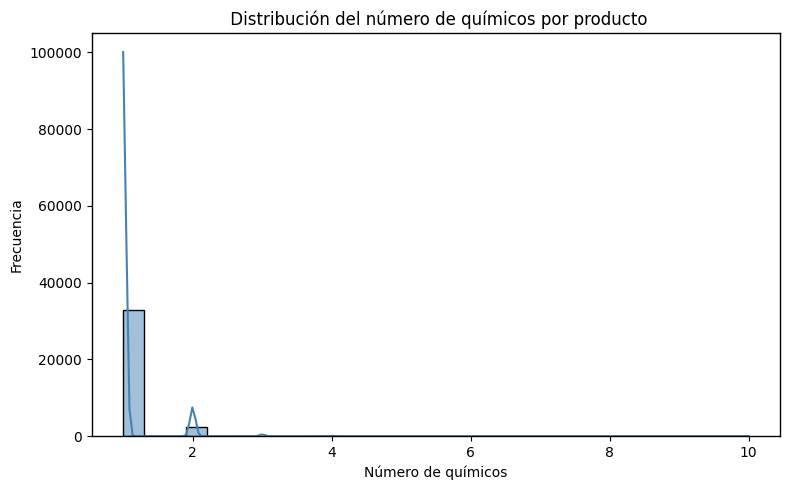

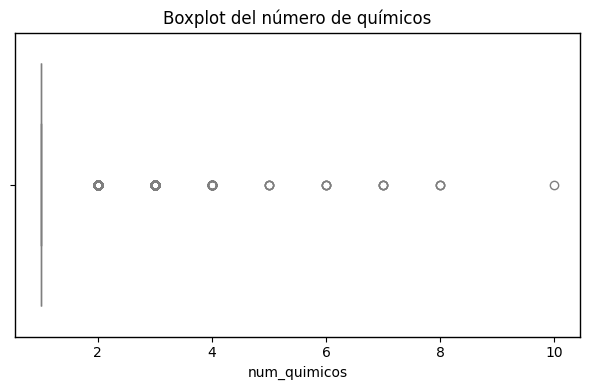

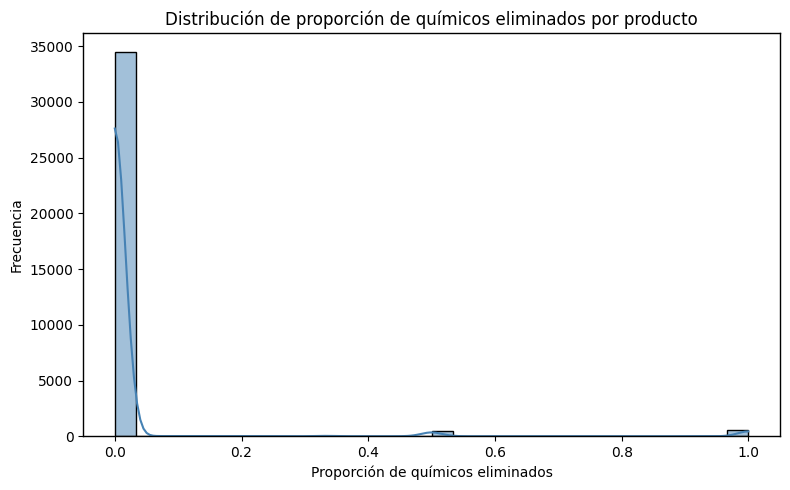

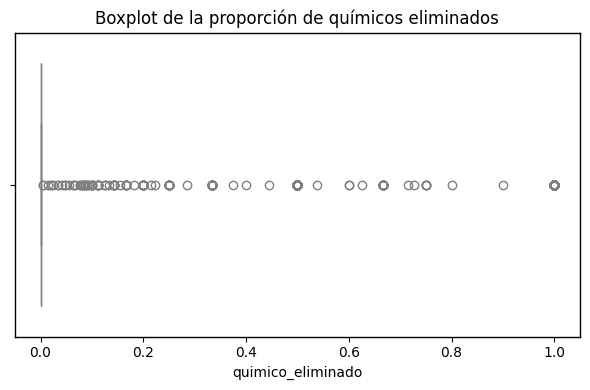

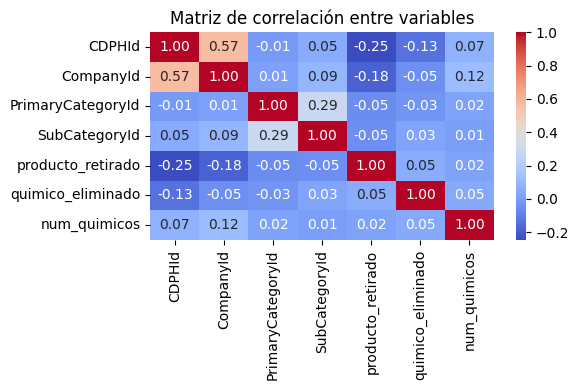

In [6]:

# Estadísticas descriptivas
stats = df_prod.describe().T
stats['asimetria'] = df_prod.skew()
stats['curtosis'] = df_prod.kurtosis()

# Mostrar tabla de estadísticas
print("Análisis estadístico descriptivo:\n")
print(stats)


# Función para bordes exteriores negros
def bordes_negros(ax):
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color("black")
        spine.set_linewidth(1)

# 1. Histograma + KDE de num_quimicos
plt.figure(figsize=(8, 5))
ax1 = sns.histplot(df_prod['num_quimicos'], kde=True, bins=30, color='steelblue')
plt.title(" Distribución del número de químicos por producto")
plt.xlabel("Número de químicos")
plt.ylabel("Frecuencia")
bordes_negros(ax1)
plt.tight_layout()

plt.show()

# 2. Boxplot de num_quimicos
plt.figure(figsize=(6, 4))
ax2 = sns.boxplot(x=df_prod['num_quimicos'], color='lightgray')
plt.title("Boxplot del número de químicos")
bordes_negros(ax2)
plt.tight_layout()

plt.show()

# 3. Histograma + KDE de quimico_eliminado
plt.figure(figsize=(8, 5))
ax3 = sns.histplot(df_prod['quimico_eliminado'], kde=True, bins=30, color='steelblue')
plt.title("Distribución de proporción de químicos eliminados por producto")
plt.xlabel("Proporción de químicos eliminados")
plt.ylabel("Frecuencia")
bordes_negros(ax3)
plt.tight_layout()

plt.show()

# 4. Boxplot de quimico_eliminado
plt.figure(figsize=(6, 4))
ax4 = sns.boxplot(x=df_prod['quimico_eliminado'], color='lightgray')
plt.title("Boxplot de la proporción de químicos eliminados")
bordes_negros(ax4)
plt.tight_layout()
plt.show()

# Matriz de correlación
plt.figure(figsize=(6, 4))
sns.heatmap(df_prod.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Matriz de correlación entre variables')
plt.tight_layout()
plt.show()

In [7]:
#Detección de outliers
outliers_data = []

for var in ['num_quimicos', 'quimico_eliminado']:
    q1 = df_prod[var].quantile(0.25)
    q3 = df_prod[var].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    num_outliers = df_prod[(df_prod[var] < lower_bound) | (df_prod[var] > upper_bound)].shape[0]

    outliers_data.append({
        'Variable': var,
        'Q1': round(q1, 2),
        'Q3': round(q3, 2),
        'IQR': round(iqr, 2),
        'Límite inferior': round(lower_bound, 2),
        'Límite superior': round(upper_bound, 2),
        'Nº de outliers': num_outliers
    })

df_outliers = pd.DataFrame(outliers_data)


print("Resumen de outliers por variable:")
display(df_outliers)

Resumen de outliers por variable:


,Variable,Q1,Q3,IQR,Límite inferior,Límite superior,Nº de outliers
0,num_quimicos,1.0,1.0,0.0,1.0,1.0,2686
1,quimico_eliminado,0.0,0.0,0.0,0.0,0.0,1132


In [8]:
print(f"Total de productos en el dataset final: {df_prod.shape[0]}")
print("Variables disponibles para análisis:")
print(df_prod.columns.tolist())

# Vista previa
df_prod.head()

Total de productos en el dataset final: 35600
Variables disponibles para análisis:
['CDPHId', 'CompanyId', 'PrimaryCategoryId', 'SubCategoryId', 'producto_retirado', 'quimico_eliminado', 'num_quimicos']


,CDPHId,CompanyId,PrimaryCategoryId,SubCategoryId,producto_retirado,quimico_eliminado,num_quimicos
0,2,4,44,53,1,0.0,1
1,3,338,18,25,0,0.0,2
2,4,4,44,46,0,0.0,1
3,5,4,44,52,1,0.0,1
4,6,4,44,48,1,0.0,1


ANÁLISIS DEL DATO

In [9]:
# Normalización z-score
X = df_prod[['num_quimicos', 'quimico_eliminado']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)



   Número de Clústeres (k)          WCSS  Silhouette
0                        2  41513.983955    0.921277
1                        3  11018.520853    0.972640
2                        4   7323.835584    0.979680
3                        5   3980.213176    0.988525
4                        6   2192.641681    0.989805


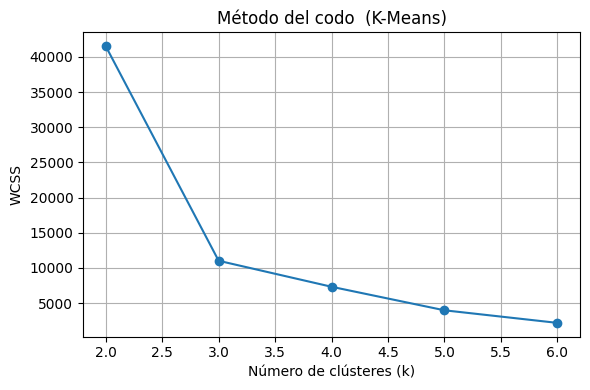

In [10]:
# Evaluar WCSS e índice de Silhouette para k de 2 a 6
inertias = []
silhouettes = []
K_range = range(2, 7)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(X_scaled, labels))

# Preparar tabla con resultados
tabla_kmeans = pd.DataFrame({
    'Número de Clústeres (k)': list(K_range),
    'WCSS': inertias,
    'Silhouette': silhouettes
})

print(tabla_kmeans)

# Mostrar gráfico del método del codo
plt.figure(figsize=(6, 4))
plt.plot(K_range, inertias, marker='o')
plt.title("Método del codo  (K-Means)")
plt.xlabel("Número de clústeres (k)")
plt.ylabel("WCSS")
plt.grid(True)
plt.tight_layout()
plt.show()

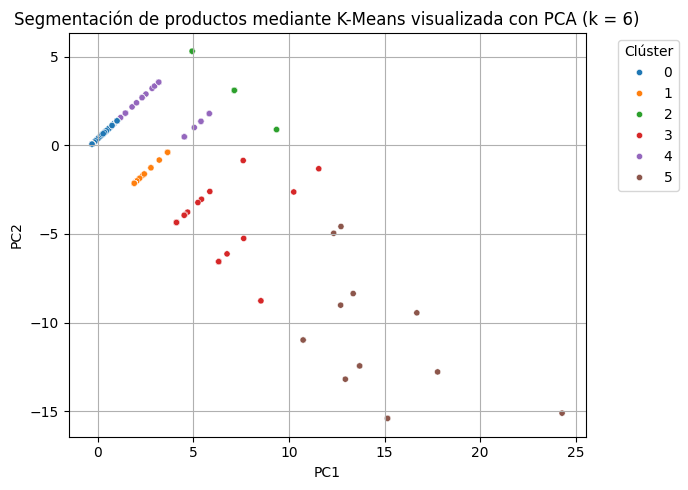

   Clúster  Número de productos  Porcentaje (%)
0        0                32043           90.01
1        1                 2364            6.64
2        2                  538            1.51
3        3                  182            0.51
4        4                  459            1.29
5        5                   14            0.04


In [ ]:

# K-Means con k=6
kmeans = KMeans(n_clusters=6, random_state=42)
df_prod['cluster_kmeans'] = kmeans.fit_predict(X_scaled)

# PCA para visualización
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
df_prod['PC1'] = X_pca[:, 0]
df_prod['PC2'] = X_pca[:, 1]


# Visualización
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='cluster_kmeans',
    data=df_prod,
    palette='tab10',
    s=20
)
plt.title("Segmentación de productos mediante K-Means visualizada con PCA (k = 6)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clúster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Mostrar número y porcentaje de productos por clúster
conteo = df_prod['cluster_kmeans'].value_counts().sort_index()
porcentaje = df_prod['cluster_kmeans'].value_counts(normalize=True).sort_index() * 100
resumen = pd.DataFrame({
    'Clúster': conteo.index,
    'Número de productos': conteo.values,
    'Porcentaje (%)': porcentaje.values.round(2)
})
print(resumen)

In [ ]:
!pip install hdbscan

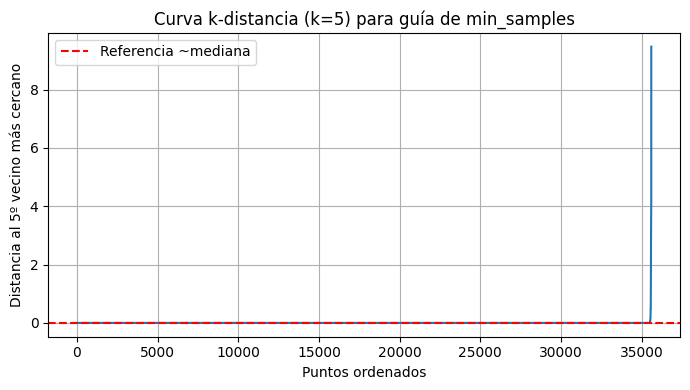

In [ ]:

k = 5 # puedes cambiarlo si lo deseas

# Calcular distancias a los k vecinos más cercanos
neigh = NearestNeighbors(n_neighbors=k)
nbrs = neigh.fit(X_scaled)
distances, indices = nbrs.kneighbors(X_scaled)

# Tomar la distancia al k-ésimo vecino más cercano para cada punto
k_distances = distances[:, k - 1]
k_distances = np.sort(k_distances)

# Graficar curva de k-distancia
plt.figure(figsize=(7, 4))
plt.plot(k_distances)
plt.axhline(y=np.median(k_distances), color='red', linestyle='--', label='Referencia ~mediana')
plt.title(f"Curva k-distancia (k={k}) para guía de min_samples")
plt.xlabel("Puntos ordenados")
plt.ylabel(f"Distancia al {k}º vecino más cercano")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


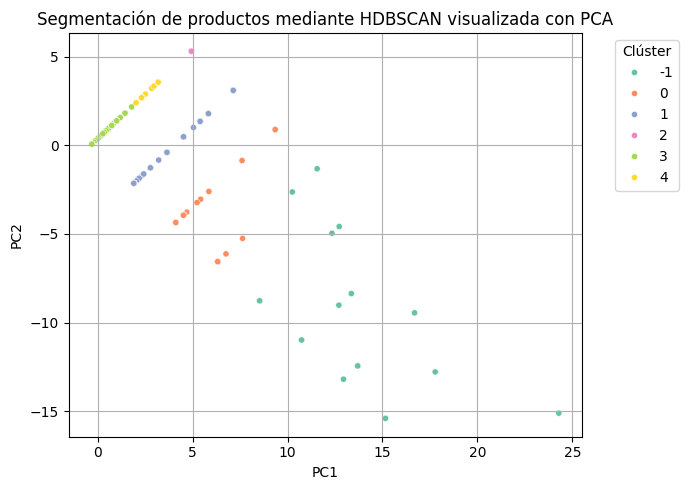

   Clúster  Número de productos  Porcentaje (%)
0       -1                   18            0.05
1        0                  180            0.51
2        1                 2488            6.99
3        2                  497            1.40
4        3                32052           90.03
5        4                  365            1.03


In [ ]:
# HDBSCAN
clusterer = hdbscan.HDBSCAN(min_cluster_size=150, min_samples=5)
df_prod['cluster_hdbscan'] = clusterer.fit_predict(X_scaled)

# Visualización
plt.figure(figsize=(7, 5))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='cluster_hdbscan',
    data=df_prod,
    palette='Set2',
    s=20
)
plt.title("Segmentación de productos mediante HDBSCAN visualizada con PCA")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Clúster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()
# Mostrar número y porcentaje de productos por clúster
conteo = df_prod['cluster_hdbscan'].value_counts().sort_index()
porcentaje = df_prod['cluster_hdbscan'].value_counts(normalize=True).sort_index() * 100
resumen = pd.DataFrame({
    'Clúster': conteo.index,
    'Número de productos': conteo.values,
    'Porcentaje (%)': porcentaje.values.round(2)
})
print(resumen)

In [ ]:
# Calcular métricas comparativas
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Filtrar datos válidos para HDBSCAN (excluyendo ruido)
mask_valid_hdbscan = df_prod['cluster_hdbscan'] != -1
X_hdbscan_valid = X_scaled[mask_valid_hdbscan]
labels_hdbscan_valid = df_prod.loc[mask_valid_hdbscan, 'cluster_hdbscan']

# Etiquetas para K-Means
labels_kmeans = df_prod['cluster_kmeans']

# Calcular métricas para ambos modelos
metricas = {
    'Modelo': ['K-Means', 'HDBSCAN'],
    'Silhouette': [
        silhouette_score(X_scaled, labels_kmeans),
        silhouette_score(X_hdbscan_valid, labels_hdbscan_valid)
    ],
    'Calinski-Harabasz': [
        calinski_harabasz_score(X_scaled, labels_kmeans),
        calinski_harabasz_score(X_hdbscan_valid, labels_hdbscan_valid)
    ],
    'Davies-Bouldin': [
        davies_bouldin_score(X_scaled, labels_kmeans),
        davies_bouldin_score(X_hdbscan_valid, labels_hdbscan_valid)
    ]
}

df_metricas = pd.DataFrame(metricas)
df_metricas

,Modelo,Silhouette,Calinski-Harabasz,Davies-Bouldin
0,K-Means,0.989805,224044.624651,0.373241
1,HDBSCAN,0.985162,137821.151492,0.244644


In [ ]:
# Filtrar solo clústeres válidos (sin ruido)
df_valid = df_prod[df_prod['cluster_hdbscan'] != -1]

# Agrupar por clúster y calcular media y desviación estándar
resumen = df_valid.groupby('cluster_hdbscan')[['num_quimicos', 'quimico_eliminado']].agg(['mean', 'std']).round(2)

# Renombrar columnas
resumen.columns = ['Media num_quimicos', 'Desv num_quimicos', 'Media quimico_eliminado', 'Desv quimico_eliminado']
resumen.reset_index(inplace=True)

# Mostrar tabla
resumen

,cluster_hdbscan,Media num_quimicos,Desv num_quimicos,Media quimico_eliminado,Desv quimico_eliminado
0,0,3.15,0.36,0.02,0.12
1,1,2.00,0.00,0.04,0.16
2,2,1.00,0.00,1.00,0.00
3,3,1.00,0.00,0.00,0.01
4,4,1.00,0.00,0.51,0.03


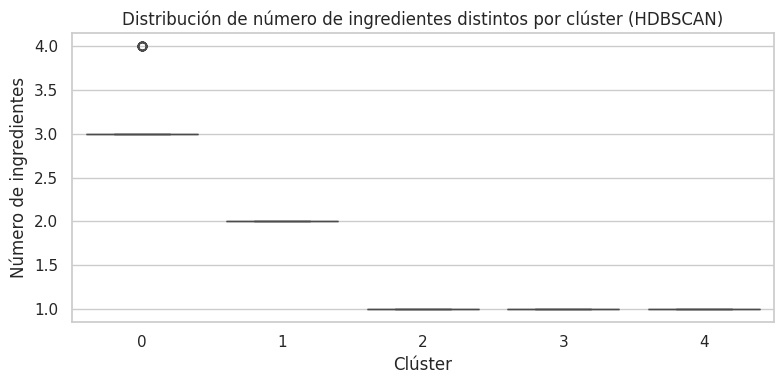

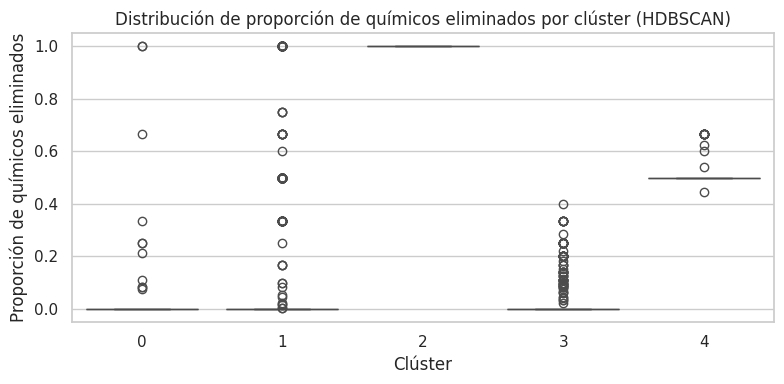

In [ ]:
# Estilo general
sns.set(style="whitegrid")

# Boxplot para num_quimicos por clúster HDBSCAN
plt.figure(figsize=(8, 4))
sns.boxplot(x='cluster_hdbscan', y='num_quimicos', data=df_valid)
plt.title('Distribución de número de ingredientes distintos por clúster (HDBSCAN)')
plt.xlabel('Clúster')
plt.ylabel('Número de ingredientes')
plt.tight_layout()
plt.show()

# Boxplot para quimico_eliminado por clúster HDBSCAN
plt.figure(figsize=(8, 4))
sns.boxplot(x='cluster_hdbscan', y='quimico_eliminado', data=df_valid)
plt.title('Distribución de proporción de químicos eliminados por clúster (HDBSCAN)')
plt.xlabel('Clúster')
plt.ylabel('Proporción de químicos eliminados')
plt.tight_layout()
plt.show()